In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from src.posterior_networks.PosteriorNetwork import PosteriorNetwork
import json
import numpy as np
import pandas as pd
import wandb
from dataset_manager.ClassificationDataset import MapillaryDataset
from src.results_manager.metrics_prior import confidence, brier_score, anomaly_detection
import torch
import torchvision.transforms as transforms
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from src.posterior_networks.config import config
import os

/nfs/homedirs/zhz/anaconda3/envs/postnet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_acc(model, loader, device):
    model.eval()
    with torch.no_grad():
        for batch_index, (X, Y) in enumerate(loader):
            Y_hot = torch.zeros(Y.shape[0], loader.dataset.output_dim)
            Y_hot.scatter_(1, Y, 1)
            X, Y_hot = X.to(device), Y_hot.to(device)
            Y_pred = model(X, Y_hot)
            if batch_index == 0:
                Y_pred_all = Y_pred.view(-1).to("cpu")
                Y_all = Y.view(-1).to("cpu")
            else:
                Y_pred_all = torch.cat([Y_pred_all, Y_pred.view(-1).to("cpu")], dim=0)
                Y_all = torch.cat([Y_all, Y.view(-1).to("cpu")], dim=0)
        accuracy = balanced_accuracy_score(Y_all, Y_pred_all)
    return accuracy

In [3]:
train_df = pd.read_csv('/lab/project-1/train_label.csv')
val_df = pd.read_csv('/lab/project-1/val_label.csv')
test_df = pd.read_csv('/lab/project-1/test_label.csv')
regions = set(['g1', 'g2', 'g3', 'g4', 'g5', 'g6'])
classes = set(['regu', 'warn', 'comp', 'info'])
full_path = 'models/resnet18_oodg3_RandAug_ops3_mag3_bins31'
# 'resnet18_oodg3_RandAug_ops3_mag3_bins31'

config = json.load(open(f'{full_path}/config.json'))
ood_regions_classes = set(config['ood_regions'].split(','))
ood_regions = ood_regions_classes.intersection(regions)
ood_classes = ood_regions_classes.intersection(classes)
train_id = train_df[~((train_df.region.isin(ood_regions)) | (train_df.label.isin(ood_classes)))]
val_id = val_df[~(((val_df.region.isin(ood_regions)) | (val_df.label.isin(ood_classes))))]
test_id = test_df[~(((test_df.region.isin(ood_regions)) | (test_df.label.isin(ood_classes))))]

train_ood = train_df[((train_df.region.isin(ood_regions)) | (train_df.label.isin(ood_classes)))]
val_ood = val_df[((val_df.region.isin(ood_regions)) | (val_df.label.isin(ood_classes)))]
test_ood = test_df[((test_df.region.isin(ood_regions)) | (test_df.label.isin(ood_classes)))]
ood = pd.concat([train_ood, val_ood, test_ood])

if 'class_encoding' in config: 
    class_encoding = config['class_encoding']
else:
    class_encoding = {c: i for i, c in enumerate(sorted(train_id.label.unique()))}
# here class_encoding = {'comp': 0, 'info': 1, 'regu': 2, 'warn': 3}
train_id['label_encoded'] = train_id.label.map(class_encoding)
val_id['label_encoded'] = val_id.label.map(class_encoding)
test_id['label_encoded'] = test_id.label.map(class_encoding)

train_ood['label_encoded'] = train_ood.label.map(class_encoding)
val_ood['label_encoded'] = val_ood.label.map(class_encoding)
test_ood['label_encoded'] = test_ood.label.map(class_encoding)

if "N" in config:
    N = config['N']
else:
    N = train_id.label_encoded.value_counts().sort_index().values
N = torch.tensor(N)

model = PosteriorNetwork(N=N,
                         n_classes=config['num_classes'],
                         hidden_dims=config['hidden_dims'],
                         kernel_dim=None,
                         latent_dim=config['latent_dim'],
                         architecture=config['architecture'],
                         k_lipschitz=config['k_lipschitz'],
                         no_density=config['no_density'],
                         density_type=config['density_type'],
                         n_density=config['n_density'],
                         budget_function=config['budget_function'],
                         batch_size=config['batch_size'],
                         lr=config['lr'],
                         loss=config['loss'],
                         dropout=config['dropout'],
                         regr=config['regr'],
                         seed=config['seed'])
model.load_state_dict(torch.load(f'{full_path}/best_model.pth')['model_state_dict'])
model.cuda()
print()
transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ])
val_id_dataset = MapillaryDataset(val_id, transform=transform_val_test)
test_id_dataset = MapillaryDataset(test_id, transform=transform_val_test)
ood_dataset = MapillaryDataset(ood, transform=transform_val_test)
test_ood_dataset = MapillaryDataset(test_ood, transform=transform_val_test)

/tmp/ipykernel_2830200/2238076086.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_id['label_encoded'] = train_id.label.map(class_encoding)
/tmp/ipykernel_2830200/2238076086.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_id['label_encoded'] = val_id.label.map(class_encoding)
/tmp/ipykernel_2830200/2238076086.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [4]:
# dict of classes
class_encoding = config['class_encoding']
print(config['class_encoding'])
get_class = {}
# len(class_encoding)
# print(class_encoding.keys())
# np.array(class_encoding.keys())
for i in range(len(class_encoding)):
    get_class[i] = list(class_encoding.keys())[i]
get_class

{'comp': 0, 'info': 1, 'regu': 2, 'warn': 3}


{0: 'comp', 1: 'info', 2: 'regu', 3: 'warn'}

In [5]:
# model.to(device)
test_loader =  torch.utils.data.DataLoader(test_id_dataset,
                                                      batch_size=config['batch_size'],
                                                      num_workers=6, pin_memory=True)
test_ood_dataloader = torch.utils.data.DataLoader(test_ood_dataset,
                                                      batch_size=config['batch_size'],
                                                      num_workers=6, pin_memory=True)
ood_dataloader = torch.utils.data.DataLoader(ood_dataset, 
                                                batch_size=config['batch_size'],
                                                num_workers=6, pin_memory=True)                                                      
model.eval()
from src.posterior_networks.test import compute_X_Y_alpha
orig_Y_all, X_duplicate_all, alpha_pred_all = compute_X_Y_alpha(model, test_loader)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [7]:
# print out index of all misclassification
pred_classes = torch.max(alpha_pred_all, dim=-1)[1]
index = []
for i in range(len(orig_Y_all)):
    if pred_classes[i] != orig_Y_all[i]:
            index.append(i)
print(index)
# # plt.imshow(torch.permute(X_duplicate_all[index[0]],(1,2,0)))
# print('ground truth:', orig_Y_all[index[0]], 'prediction:', pred_classes[index[0]])
# # plt.show(test_id_dataset[index[0]])

[0, 11, 74, 92, 169, 172, 195, 196, 223, 296, 308, 345, 431, 468, 493, 504, 516, 549, 603, 615, 675, 748, 803, 842, 846, 881, 975, 993, 999]


In [200]:
test_sign_path = '/lab/project-1/test_signs'
train_sign_path = '/lab/project-1/train_signs'
val_sign_path = '/lab/project-1/val_signs'

# total confidence of this test-set
c=confidence(Y= orig_Y_all, alpha=alpha_pred_all, score_type='APR', uncertainty_type='aleatoric')
print(c)
c2=confidence(Y= orig_Y_all, alpha=alpha_pred_all, score_type='APR', uncertainty_type='epistemic')
print(c2)

predict class warn
ground truth warn
0.9983139369782439
0.9984580335129459


In [ ]:
corrects = (orig_Y_all.squeeze() == alpha_pred_all.max(-1)[1]).type(torch.DoubleTensor)
# print(corrects)
p=torch.nn.functional.normalize(alpha_pred_all, p=1, dim=-1)
scores_aleatoric = p.max(-1)[0].cpu().detach().numpy()
print('aleatoric score:',scores_aleatoric)
scores_epistemic = alpha_pred_all.max(-1)[0].cpu().detach().numpy()
print('epistemic score:',scores_epistemic)
# confidence is based on multiple precision-recall curve
# this cannot be calculated with only 1 example

In [13]:
# check OOD detection
ood_orig_Y_all, X_duplicate_all, ood_alpha_pred_all = compute_X_Y_alpha(model, ood_dataloader)
ood_pred_classes = torch.max(ood_alpha_pred_all, dim=-1)
anomaly_aleatoric = anomaly_detection(alpha=alpha_pred_all, ood_alpha=ood_alpha_pred_all, \
                                    score_type='APR', uncertainty_type='aleatoric')
anomaly_aleatoric

0.6637564129973703

In [199]:
# print out index of all misclassification of ood classes
ood_pred_classes = torch.max(ood_alpha_pred_all, dim=-1)[1]
ood_index = []
for i in range(len(ood_orig_Y_all)):
    if ood_pred_classes[i] != ood_orig_Y_all[i]:
            ood_index.append(i)
print('misclassified index of imgs',ood_index)
j = 2
print('predict class', get_class[ood_pred_classes[j].item()])
print('ground truth', get_class[ood_orig_Y_all[j].item()])
sign_key = test_ood_dataset.img_labels.sign_key.iloc[j]+'.npy'
# len(ood_dataset.img_labels.sign_key)
# print(ood_dataset.img_labels.sign_key.iloc[j])
# ood_dataset.img_labels.sign_key
os.path.join(test_sign_path, sign_key)
sign_img = np.load(os.path.join(test_sign_path, sign_key))
# plt.imshow(sign_img)

# epistemic uncertainty
ood_scores_epistemic = ood_alpha_pred_all.sum(-1).cpu().detach().numpy()
print('epistemic uncertainty score:', ood_scores_epistemic)
# aleatoric uncertainty
p = torch.nn.functional.normalize(ood_alpha_pred_all, p=1, dim=-1) 
ood_scores_aleatoric = p.max(-1)[0].cpu().detach().numpy()
print('aleatoric uncertainty score:', ood_scores_aleatoric)

misclassified index of imgs [2, 6, 11, 21, 23, 24, 39, 41, 45, 49, 50, 52, 53, 54, 55, 78, 84, 89, 101, 114, 117, 123, 124, 133, 136, 137, 140, 144, 145, 149, 151, 154, 156, 157, 158, 161, 162, 163, 167, 199, 201, 202, 219, 241, 248, 261, 271, 282, 301, 302, 313, 317, 331, 334, 340, 343, 344, 347, 354, 364, 366, 371, 401, 408, 432, 437, 439, 442, 447, 461, 476, 482, 486, 487, 510, 516, 517, 528, 531, 532, 564, 565, 574, 577, 580, 595, 607, 610, 622, 636, 653, 655, 673, 677, 679, 681, 684, 691, 698, 703, 704, 710, 711, 725, 732, 740, 744, 753, 754, 755, 756, 765, 786, 800, 815, 817, 834, 837, 849, 853, 854, 879, 903, 905, 924, 927, 936, 942, 944, 960, 961, 964, 970, 972, 986, 996]
predict class comp
ground truth regu
epistemic uncertainty score: [1.62346857e+04 1.14856619e+04 3.11494727e+02 1.01516412e+04
 1.85606426e+04 1.89306988e+04 4.28869835e+02 1.23935975e+03
 4.38248743e+02 4.14051015e+02 2.24450796e+04 7.66494219e+02
 1.55028731e+04 3.31277193e+02 1.74843569e+04 5.58160111e+03
 

In [76]:
def get_path(sign_key):
    if os.path.exists(os.path.join(test_sign_path, sign_key)):
        path = os.path.join(test_sign_path, sign_key)
    elif os.path.exists(os.path.join(val_sign_path, sign_key)):
        path = os.path.join(val_sign_path, sign_key)
    elif os.path.exists(os.path.join(train_sign_path, sign_key)):
        path = os.path.join(train_sign_path, sign_key)
    else:
        KeyError('no such image')
    return path

In [184]:
def show_signs(ood_pred_classes, ood_orig_Y_all, index, imgs, scores):
    plt.figure()
    plt.subplots(2,5,figsize=(10,10))
    plt.subplot(2,5,1)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[0]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[0]].item()]+'\n'
            'score:'+str(round(scores[index[0]],4)))
    plt.axis('off')
    plt.imshow(imgs[0])

    plt.subplot(2,5,2)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[1]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[1]].item()]+'\n'
            'score:'+str(round(scores[index[1]],4)))
    plt.axis('off')
    plt.imshow(imgs[1])

    plt.subplot(2,5,3)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[2]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[2]].item()]+'\n'
            'score:'+str(round(scores[index[2]],4)))
    plt.axis('off')
    plt.imshow(imgs[2])

    plt.subplot(2,5,4)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[3]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[3]].item()]+'\n'
            'score:'+str(round(scores[index[3]],4)))
    plt.axis('off')
    plt.imshow(imgs[3])
        
    plt.subplot(2,5,5)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[4]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[4]].item()]+'\n'
            'score:'+str(round(scores[index[4]],4)))
    plt.axis('off')
    plt.imshow(imgs[4])

    plt.subplot(2,5,6)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[5]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[5]].item()]+'\n'
            'score:'+str(round(scores[index[5]],4)))
    plt.axis('off')
    plt.imshow(imgs[5])

    plt.subplot(2,5,7)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[6]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[6]].item()]+'\n'
            'score:'+str(round(scores[index[6]],4)))
    plt.axis('off')
    plt.imshow(imgs[6])

    plt.subplot(2,5,8)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[7]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[7]].item()]+'\n'
            'score:'+str(round(scores[index[7]],4)))
    plt.axis('off')
    plt.imshow(imgs[7])

    plt.subplot(2,5,9)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[8]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[8]].item()]+'\n'
            'score:'+str(round(scores[index[8]],4)))
    plt.axis('off')
    plt.imshow(imgs[8])
        
    plt.subplot(2,5,10)
    plt.title('predict class:'+ get_class[ood_pred_classes[index[9]].item()]+'\n'
            'ground truth:' + get_class[ood_orig_Y_all[index[9]].item()]+'\n'
            'score:'+str(round(scores[index[9]],4)))
    plt.axis('off')
    plt.imshow(imgs[9])
    plt.show()

[87, 706, 782, 995, 110, 598, 88, 289, 560, 217]


<Figure size 640x480 with 0 Axes>

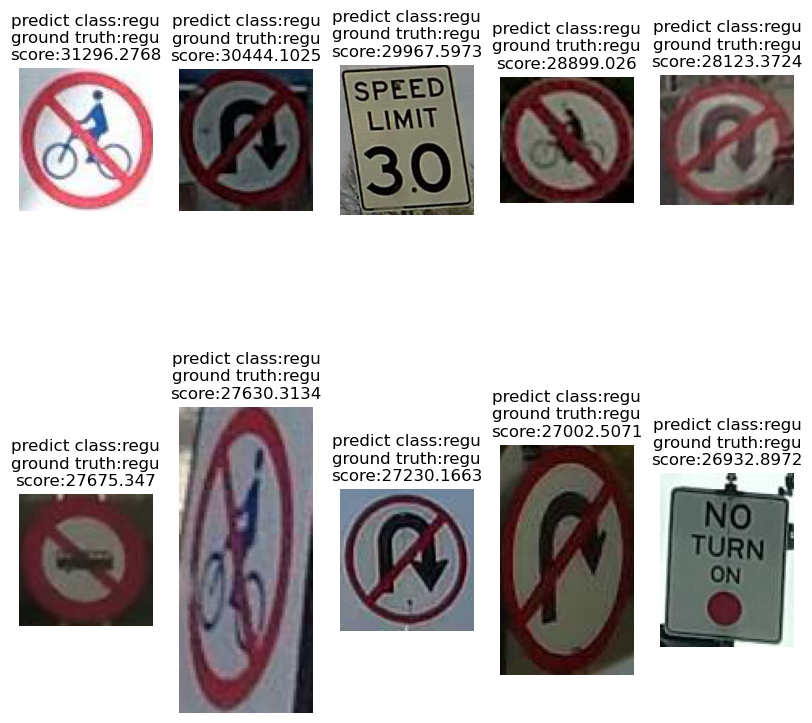

In [190]:
# Find highest epistemic scores in ood_dataset
max_epi_index = pd.Series(ood_scores_epistemic).sort_values(ascending=False).index[:10].tolist()
print(max_epi_index)
max_epi_imgs = []

for i in max_epi_index:
    # print('predict class', get_class[ood_pred_classes[i].item()])
    # print('ground truth', get_class[ood_orig_Y_all[i].item()])
    # print('epistemic score:',ood_scores_epistemic[i])
    test_sign_path = '/lab/project-1/test_signs'
    sign_key = ood_dataset.img_labels.sign_key.iloc[i]+'.npy'
    path = get_path(sign_key)
    max_epi_imgs.append(np.load(path))

show_signs(ood_pred_classes, ood_orig_Y_all, max_epi_index, max_epi_imgs, ood_scores_epistemic)

[241, 248, 703, 704, 89, 837, 817, 114, 21, 516]


<Figure size 640x480 with 0 Axes>

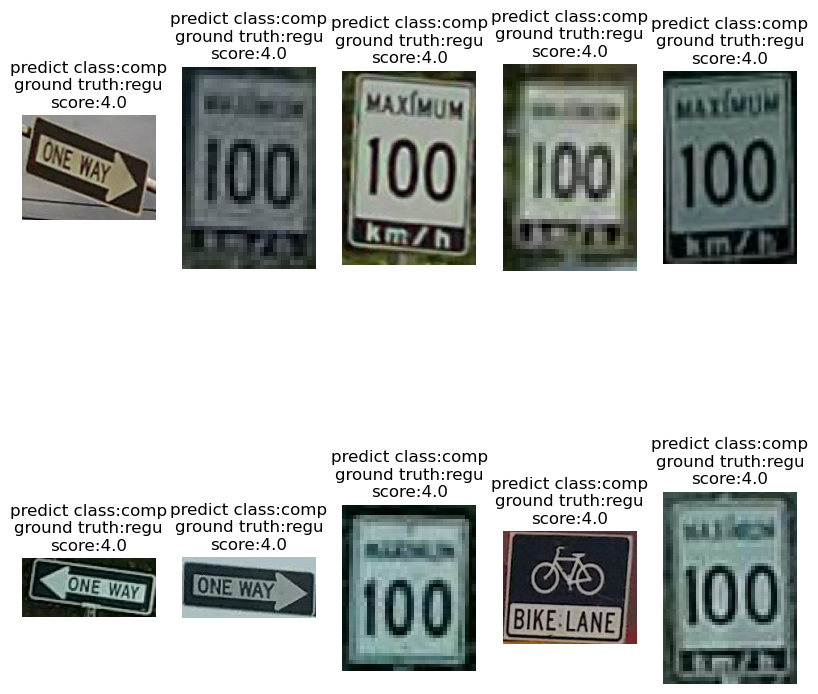

In [191]:
# Find lowest epistemic scores in ood_dataset
# low epistemic score means misclassification
min_epi_index = pd.Series(ood_scores_epistemic).sort_values().index[:10].tolist()
print(min_epi_index)
min_epi_imgs = []

for i in min_epi_index:
    # print('predict class', get_class[ood_pred_classes[i].item()])
    # print('ground truth', get_class[ood_orig_Y_all[i].item()])
    # print('epistemic score:',ood_scores_epistemic[i])
    sign_key = ood_dataset.img_labels.sign_key.iloc[i]+'.npy'
    path = get_path(sign_key)
    min_epi_imgs.append(np.load(path))

show_signs(ood_pred_classes, ood_orig_Y_all, min_epi_index, min_epi_imgs, ood_scores_epistemic)

[706, 87, 110, 995, 560, 289, 782, 88, 416, 598]


<Figure size 640x480 with 0 Axes>

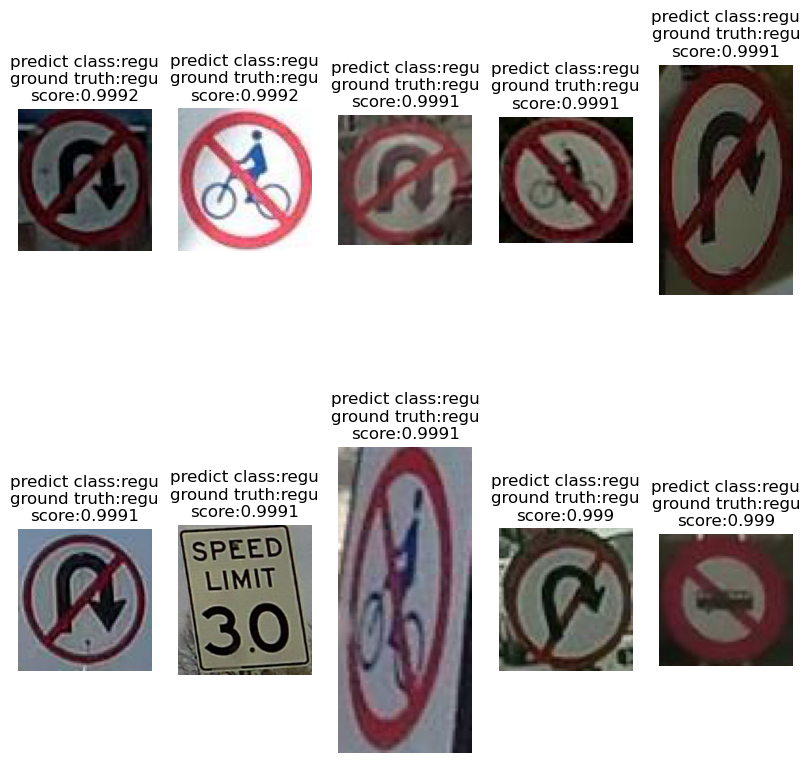

In [194]:
# Find highest aleatoric scores in ood_dataset
# highest aleatoric means correct classification
max_alea_index = pd.Series(ood_scores_aleatoric).sort_values(ascending=False).index[:10].tolist()
print(max_alea_index)
max_alea_imgs = []

for i in max_alea_index:
    # print('predict class', get_class[ood_pred_classes[i].item()])
    # print('ground truth', get_class[ood_orig_Y_all[i].item()])
    # print('aleatoric score:',ood_scores_aleatoric[i])
    sign_key = ood_dataset.img_labels.sign_key.iloc[i]+'.npy'
    path = get_path(sign_key)
    max_alea_imgs.append(np.load(path))

show_signs(ood_pred_classes, ood_orig_Y_all, max_alea_index, max_alea_imgs, ood_scores_aleatoric)

[163, 704, 837, 89, 516, 241, 21, 50, 302, 248]


<Figure size 640x480 with 0 Axes>

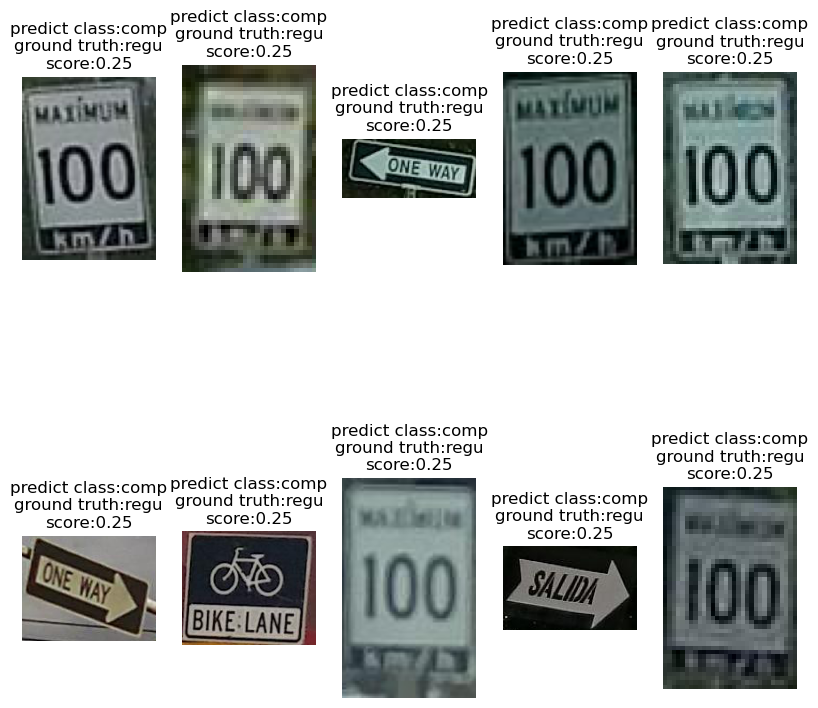

In [198]:
# Find lowest aleatoric scores in ood_dataset
# lower aleatoric means correct classification
min_alea_index = pd.Series(ood_scores_aleatoric).sort_values().index[:10].tolist()
print(min_alea_index)
min_alea_imgs = []

for i in min_alea_index:
    # print('predict class', get_class[ood_pred_classes[i].item()])
    # print('ground truth', get_class[ood_orig_Y_all[i].item()])
    # print('aleatoric score:',ood_scores_aleatoric[i])
    sign_key = ood_dataset.img_labels.sign_key.iloc[i]+'.npy'
    path = get_path(sign_key)
    min_alea_imgs.append(np.load(path))

show_signs(ood_pred_classes, ood_orig_Y_all, min_alea_index, min_alea_imgs, ood_scores_aleatoric)

In [196]:
max_epi_index

[87, 706, 782, 995, 110, 598, 88, 289, 560, 217]

In [197]:
min_alea_index

[163, 704, 837, 89, 516, 241, 21, 50, 302, 248]

In [27]:
list_ood_epistemic=ood_scores_epistemic.tolist()
type(list_ood_epistemic)

list

In [16]:
ood_scores_epistemic.max() # should not be the case for ood

31296.276790367167